In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio as rio
from rasterio import mask
from shapely.geometry import Polygon
from mpl_toolkits.basemap import Basemap  
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import numpy as np
import os
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns

all_DEMs =  gpd.read_file('Plotting\\labels\\all_DEM_labels.geojson')
all_OP =  gpd.read_file('Plotting\\labels\\all_OP_labels.geojson')
common_DEMs = gpd.read_file('Plotting\\labels\\common_DEM_labels.geojson')
common_OT = gpd.read_file('Plotting\\labels\\all_OT_labels.geojson')

In [11]:
import geopandas as gpd

# Read Kim's labels
kim_Peel = gpd.read_file(r'Kim_labels\Peel2_Kim.geojson')
kim_tuktoyaktuk = gpd.read_file(r'Kim_labels\Tuktoyaktuk_KimBuehler.geojson')
kim_yamal = gpd.read_file(r'Kim_labels\Yamal_KimBuehler.geojson')

# Calculate area of Kim's labels
kim_Peel['area'] = kim_Peel.geometry.area
kim_tuktoyaktuk['area'] = kim_tuktoyaktuk.geometry.area
kim_yamal['area'] = kim_yamal.geometry.area

# Concatenate all Kim's labels
kim_all = pd.concat([kim_Peel, kim_tuktoyaktuk, kim_yamal])

# Calculate average area of Kim's labels
kims_area = kim_all['area'].mean()

# Assume `all_DEMs` is a GeoDataFrame already loaded in the environment
# Calculate area of all labels
all_DEMs['area'] = all_DEMs.geometry.area
my_area = all_DEMs['area'].mean()

# Print results
print('Average area of Kim labels:', kims_area)
print('Average area of my labels:', my_area)


Average area of Kim labels: 9598.287378726454
Average area of my labels: 15189.194915254237


              landcover_type     dataset          area
0   Bare / sparse vegetation          OP   6297.084244
1   Bare / sparse vegetation          OT  42257.815135
2   Bare / sparse vegetation     all DEM  11600.000000
3   Bare / sparse vegetation  common DEM  16800.000000
4                  Grassland          OP   2235.376989
5                  Grassland          OT   3100.174970
6                  Grassland     all DEM   5550.000000
7                  Grassland  common DEM   4900.000000
8         Herbaceous wetland          OP   1990.629637
9         Herbaceous wetland     all DEM   3000.000000
10           Moss and lichen          OP   5500.380958
11           Moss and lichen          OT  10574.918425
12           Moss and lichen     all DEM  13700.000000
13           Moss and lichen  common DEM  12000.000000
14    Permanent water bodies          OP   3516.865811
15    Permanent water bodies          OT   6296.866318
16    Permanent water bodies     all DEM   4300.000000
17    Perm

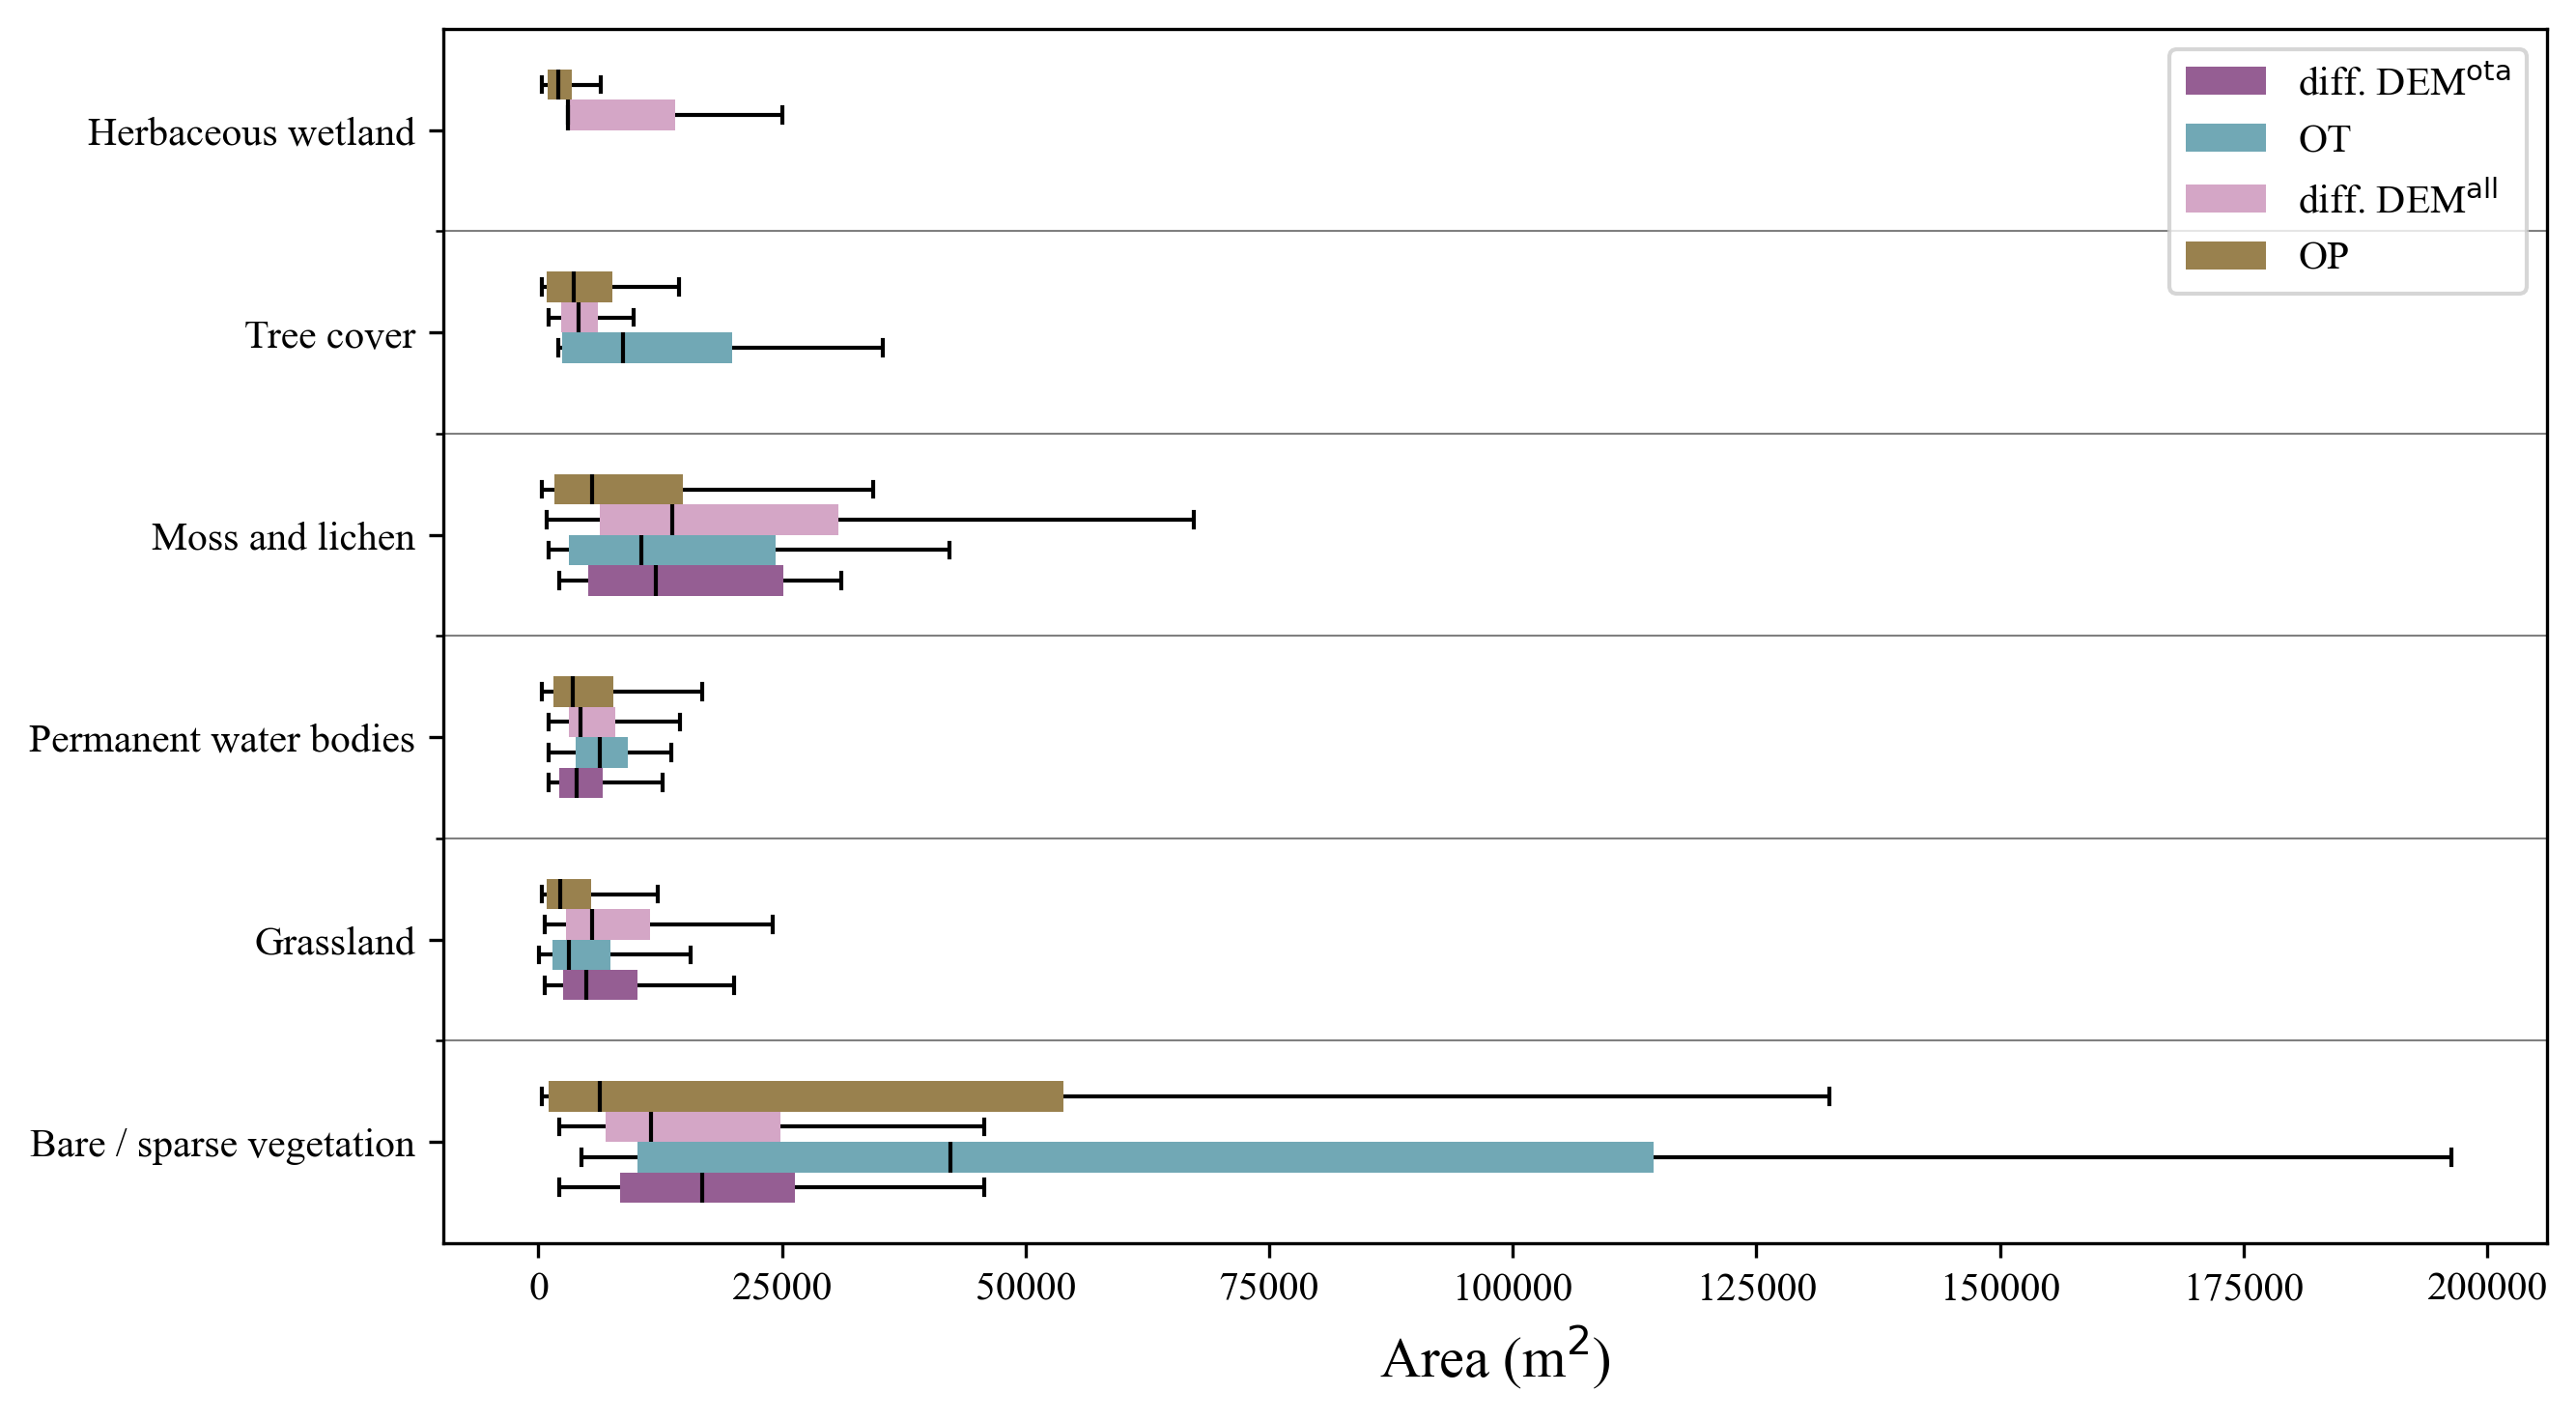

                                  df        sum_sq       mean_sq          F  \
C(landcover_type)                5.0  2.725496e+11  5.450992e+10  54.827609   
C(dataset)                       3.0  1.699827e+10  5.666090e+09   5.699113   
C(landcover_type):C(dataset)    15.0  1.197714e+11  7.984757e+09   8.031293   
Residual                      2304.0  2.290650e+12  9.942056e+08        NaN   

                                    PR(>F)  
C(landcover_type)             5.876102e-54  
C(dataset)                    6.941682e-04  
C(landcover_type):C(dataset)  5.153938e-18  
Residual                               NaN  


In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Load the datasets
all_DEMs = gpd.read_file('Plotting/labels/all_DEM_labels.geojson')
all_OP = gpd.read_file('Plotting/labels/all_OP_labels.geojson')
common_DEMs = gpd.read_file('Plotting/labels/common_DEM_labels.geojson')
common_OT = gpd.read_file('Plotting/labels/all_OT_labels.geojson')

# Set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Prepare the plot data
common_DEMs['dataset'] = 'common DEM'
common_OT['dataset'] = 'OT'
all_DEMs['dataset'] = 'all DEM'
all_OP['dataset'] = 'OP'

# Calculate the count of occurrences for each landcover type
counts_common_dem = common_DEMs['landcover_type'].value_counts()
counts_common_ot = common_OT['landcover_type'].value_counts()
counts_all_dem = all_DEMs['landcover_type'].value_counts()
counts_all_ot = all_OP['landcover_type'].value_counts()

# Filter out landcover types with 2 or fewer occurrences
filtered_landcover_common_dem = counts_common_dem[counts_common_dem > 2].index.tolist()
filtered_landcover_common_ot = counts_common_ot[counts_common_ot > 2].index.tolist()
filtered_landcover_all_dem = counts_all_dem[counts_all_dem > 2].index.tolist()
filtered_landcover_all_ot = counts_all_ot[counts_all_ot > 2].index.tolist()

# Filter the datasets
common_DEM_filtered = common_DEMs[common_DEMs['landcover_type'].isin(filtered_landcover_common_dem)]
common_OT_filtered = common_OT[common_OT['landcover_type'].isin(filtered_landcover_common_ot)]
all_DEM_filtered = all_DEMs[all_DEMs['landcover_type'].isin(filtered_landcover_all_dem)]
all_OP_filtered = all_OP[all_OP['landcover_type'].isin(filtered_landcover_all_ot)]

# Combine all the filtered datasets and add a placeholder for spacing
combined_data = pd.concat([common_DEM_filtered, common_OT_filtered, all_DEM_filtered, all_OP_filtered])
combined_data['custom_order'] = combined_data['dataset'].apply(lambda x: {'common DEM': 0, 'OT': 1, 'all DEM': 3, 'OP': 4}[x])

# Calculate medians for each combination of landcover type and dataset
medians = combined_data.groupby(['landcover_type', 'dataset'])['area'].median().reset_index()

# Print the median values
print(medians)

# Create the combined plot
plt.figure(figsize=(9, 5), dpi=300)  # Set the dpi parameter for higher resolution
ax = sns.boxplot(
    y='landcover_type', 
    x='area', 
    hue='custom_order', 
    data=combined_data,
    palette=['#9E559C', '#66AFC0', '#DC9EC9', '#A58542'],
    width=0.6, 
    showfliers=False,
    boxprops=dict(edgecolor='none')  # Remove the black frame around the bars
)

# Adjust the color of the median lines and whiskers to black
for median in ax.artists:
    median.set_edgecolor('none')

for line in ax.lines:
    line.set_color('black')

# Adjust legend labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['diff. DEM$^{\\text{ota}}$', 'OT', 'diff. DEM$^{\\text{all}}$', 'OP'], title='')

# Set the title and labels
ax.set_title('', fontsize=16)
ax.set_xlabel('Area (m$^\\text{2}$)', fontsize=14)
ax.set_ylabel('', fontsize=14)

# Customize the grid and layout
ax.yaxis.set_minor_locator(ticker.FixedLocator([y + 0.5 for y in range(len(ax.get_yticks()) - 1)]))
ax.grid(which='major', axis='y', linestyle='', lw=0)
ax.grid(which='minor', axis='y', linestyle='-', lw=1)
ax.grid(True, which='minor', color='gray', linestyle='-', linewidth=0.5)

# Set invert y-axis
plt.gca().invert_yaxis()

# Adjust layout for tight fit
plt.tight_layout()

# Save the figure with high resolution
plt.savefig('high_resolution_plot.png', dpi=300)
plt.show()

# Perform ANOVA to check if the landcover type leads to significant differences in area
anova_results = anova_lm(ols('area ~ C(landcover_type) + C(dataset) + C(landcover_type):C(dataset)', data=combined_data).fit())

# Print ANOVA results
print(anova_results)


             landcover_type  all_DEM_count  OP_count
0  Bare / sparse vegetation             39     107.0
1                  Built-up              2       0.0
2                 Grassland            226     541.0
3        Herbaceous wetland              3      49.0
4           Moss and lichen            133     589.0
5    Permanent water bodies             50     151.0
6                 Shrubland              1       2.0
7                Tree cover             18      84.0


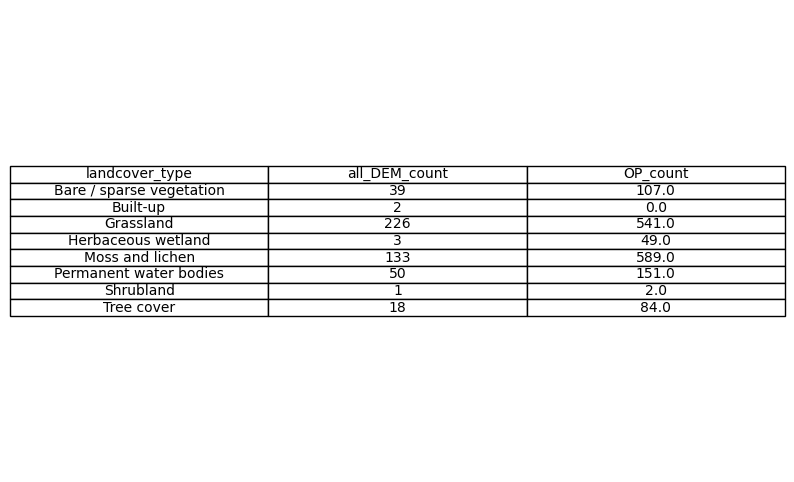

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the datasets
all_DEMs = gpd.read_file('Plotting/labels/all_DEM_labels.geojson')
all_OP = gpd.read_file('Plotting/labels/all_OP_labels.geojson')

# Prepare the plot data
all_DEMs['dataset'] = 'all DEM'
all_OP['dataset'] = 'OP'

# Calculate the count of occurrences for each landcover type in both datasets
counts_all_dem = all_DEMs['landcover_type'].value_counts().reset_index()
counts_all_op = all_OP['landcover_type'].value_counts().reset_index()

# Rename columns for better understanding
counts_all_dem.columns = ['landcover_type', 'all_DEM_count']
counts_all_op.columns = ['landcover_type', 'OP_count']

# Merge the counts into a single DataFrame
counts_merged = pd.merge(counts_all_dem, counts_all_op, on='landcover_type', how='outer').fillna(0)

# Print the table
print(counts_merged)

# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=counts_merged.values,
                 colLabels=counts_merged.columns,
                 cellLoc = 'center', 
                 loc='center')

plt.show()


             landcover_type  all_DEM_count  OP_count  common_DEM_count  \
0  Bare / sparse vegetation             39     107.0              24.0   
1                  Built-up              2       0.0               2.0   
2                 Grassland            226     541.0             106.0   
3        Herbaceous wetland              3      49.0               2.0   
4           Moss and lichen            133     589.0              39.0   
5    Permanent water bodies             50     151.0              22.0   
6                 Shrubland              1       2.0               0.0   
7                Tree cover             18      84.0               2.0   

   OT_count  
0      20.0  
1       0.0  
2      80.0  
3       2.0  
4      30.0  
5      10.0  
6       0.0  
7       4.0  


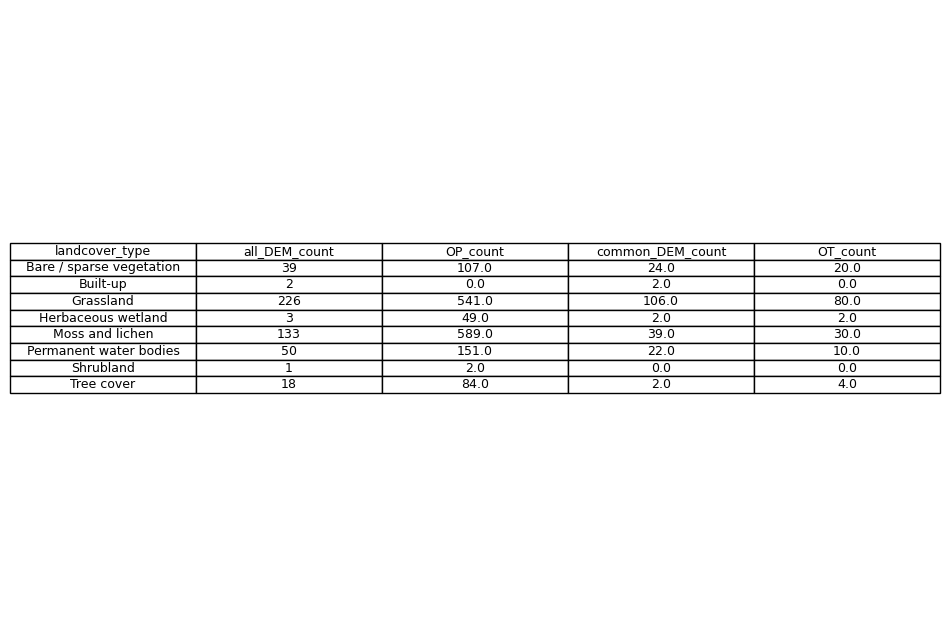

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the datasets
all_DEMs = gpd.read_file('Plotting/labels/all_DEM_labels.geojson')
all_OP = gpd.read_file('Plotting/labels/all_OP_labels.geojson')
common_DEMs = gpd.read_file('Plotting/labels/common_DEM_labels.geojson')
common_OT = gpd.read_file('Plotting/labels/all_OT_labels.geojson')

# Prepare the plot data
all_DEMs['dataset'] = 'all DEM'
all_OP['dataset'] = 'OP'
common_DEMs['dataset'] = 'common DEM'
common_OT['dataset'] = 'OT'

# Calculate the count of occurrences for each landcover type in each dataset
counts_all_dem = all_DEMs['landcover_type'].value_counts().reset_index()
counts_all_op = all_OP['landcover_type'].value_counts().reset_index()
counts_common_dem = common_DEMs['landcover_type'].value_counts().reset_index()
counts_common_ot = common_OT['landcover_type'].value_counts().reset_index()

# Rename columns for better understanding
counts_all_dem.columns = ['landcover_type', 'all_DEM_count']
counts_all_op.columns = ['landcover_type', 'OP_count']
counts_common_dem.columns = ['landcover_type', 'common_DEM_count']
counts_common_ot.columns = ['landcover_type', 'OT_count']

# Merge the counts into a single DataFrame
counts_merged = pd.merge(counts_all_dem, counts_all_op, on='landcover_type', how='outer').fillna(0)
counts_merged = pd.merge(counts_merged, counts_common_dem, on='landcover_type', how='outer').fillna(0)
counts_merged = pd.merge(counts_merged, counts_common_ot, on='landcover_type', how='outer').fillna(0)

# Print the table
print(counts_merged)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=counts_merged.values,
                 colLabels=counts_merged.columns,
                 cellLoc = 'center', 
                 loc='center')

plt.show()
